#  Graph Basics

In [1]:
using Plots

## What is a Graph?

A *graph* is a way to represent relationships between objects. It consists of a set of *vertices* (or *nodes*) and a set of *edges* (or *links*) that connect pairs of vertices.

* In a **directed graph**, edges have a direction (e.g., vertex A points to vertex B). 
* In an **undirected graph**, edges are bidirectional (e.g., A is connected to B).

![Directed_acyclic_graph](directed_acyclic_graph.png "Directed graph")

### Representing a Graph: Adjacency Lists

There are many ways to represent a graph in a computer. A common and flexible method is an *adjacency list*. 

1.  We'll number our vertices starting from $1, 2, \ldots, n$.
2.  We'll have a main list (like an array) of all our vertices.
3.  Each vertex object will then store its own list of *neighbors*, the indices of the other vertices it has an edge *to*.

To implement this, let's first define a Julia `struct` to represent a single vertex. It will hold its list of neighbors and, for visualization, its 2D coordinates.

In [2]:
struct Vertex
    # A list of integers (indices) specifying which vertices this vertex points to
    neighbors::Vector{Int}       
    
    # 2D coordinates [x, y] for plotting (optional)
    coordinates::Vector{Float64} 
    
    # An inner constructor to provide a default value for coordinates
    Vertex(neighbors; coordinates=[0,0]) = new(neighbors, coordinates)
end

# This overloads the 'show' function to print a Vertex more nicely
function Base.show(io::IO, v::Vertex)
    print(io, "Neighbors = ", v.neighbors)
end

Now, the graph itself can be represented as a struct that simply contains a list (a `Vector`) of these `Vertex` objects. The index of a vertex in this list *is* its number (e.g., the vertex at `g.vertices[3]` is vertex 3).

In [3]:
struct Graph
    # A list containing all the Vertex objects in the graph
    vertices::Vector{Vertex}
end

# Overload 'show' to print the whole graph in a readable way
function Base.show(io::IO, g::Graph)
    for i = 1:length(g.vertices)
        println(io, "Vertex $i, ", g.vertices[i])
    end
end

### Example: A Simple Directed Graph

Let's create a graph with 4 vertices. The connections will be:

```
  Vertex 1 -> Vertex 4
  Vertex 2 -> Vertices 1, 4
  Vertex 3 -> (No connections)
  Vertex 4 -> Vertex 2
```

We also provide $x,y$ coordinates for plotting.

In [4]:
# Vertex 1 points to vertex 4
v1 = Vertex([4], coordinates=[1,0.5])

# Vertex 2 points to vertices 1 and 4
v2 = Vertex([1,4], coordinates=[0,2])

# Vertex 3 has no neighbors (an empty list)
v3 = Vertex([], coordinates=[-1,1])

# Vertex 4 points to vertex 2
v4 = Vertex([2], coordinates=[2,2])

# The graph is the collection of these vertices in order
g = Graph([v1,v2,v3,v4])

Vertex 1, Neighbors = [4]
Vertex 2, Neighbors = [1, 4]
Vertex 3, Neighbors = Int64[]
Vertex 4, Neighbors = [2]


## Plotting a Graph

The code below defines a custom *plot recipe* for our `Graph` struct. The result is that we can now just call `plot(g)` on a `Graph` object, and `Plots.jl` will know how to draw it using the coordinates and neighbor lists we provided.

You don't need to understand the details of this function, just how to use it!

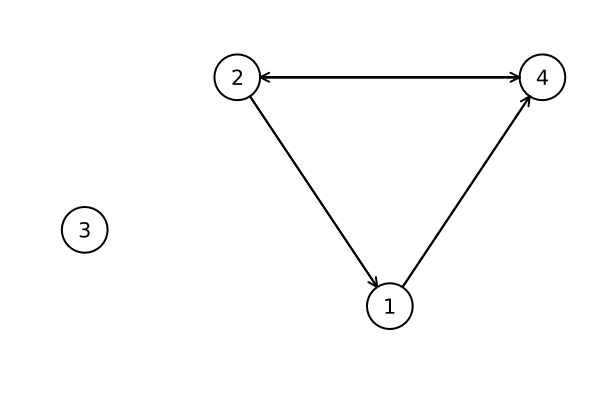

In [5]:
# This function tells Plots.jl how to handle an object of type 'Graph'
function Plots.plot(g::Graph; scale=1.0)
    # Get the bounding box of the coordinates to set plot limits
    xmin,xmax = extrema(v.coordinates[1] for v in g.vertices)
    ymin,ymax = extrema(v.coordinates[2] for v in g.vertices)

    sz = max(xmax-xmin, ymax-ymin)
    cr = scale*0.05sz # Circle radius
    hw = cr/2 # Not used here, but good for arrowheads

    # Set up a blank plot with no grid or axes, and equal aspect ratio
    plot(legend=false, grid=false, showaxis=false, aspect_ratio=:equal,
         xlims=[xmin-2cr, xmax+2cr], ylims=[ymin-2cr,ymax+2cr])
    
    # Points for drawing a circle
    npnts = 32
    ϕ = 2π*(0:npnts)/npnts
    cx,cy = cos.(ϕ), sin.(ϕ)    

    # Draw each vertex as a circle with its number
    for i = 1:length(g.vertices)
        c = g.vertices[i].coordinates
        plot!(c[1] .+ cr*cx, c[2] .+ cr*cy, color=:black, linewidth=2)
        annotate!(c[1], c[2], text("$i", round(Int, 14*scale), :center))
        
        # For each neighbor, draw a directed edge (arrow)
        for nb in g.vertices[i].neighbors
            cnb = g.vertices[nb].coordinates
            dc = cnb .- c
            L = sqrt(sum(dc.^2))
            # Shorten the line so it starts/ends at the circle edge
            c1 = c .+ cr/L * dc
            c2 = cnb .- cr/L * dc
            plot!([c1[1],c2[1]], [c1[2],c2[2]],
                  arrow=:simple, color=:black, linewidth=2)
        end
    end
    return plot!() # Return the final plot
end

# Now we can just plot our graph object!
plot(g)

## Creating Graphs Programmatically

We can write functions to *generate* graphs. The function below creates an **undirected cycle graph** with `nv` vertices, arranged visually in a circle.

Note: to make an edge *undirected*, if vertex `i` points to vertex `j`, we must also make vertex `j` point to vertex `i`.

In [6]:
function circle_graph(nv=8)
    # Start with an empty graph
    g = Graph(Vertex[])
    
    for i = 1:nv
        # Calculate the angle for this vertex
        th = 2π*i/nv
        
        # Get neighbors: the vertex before (i-1) and after (i+1)
        # 'mod(i,nv)+1' is the next vertex, wrapping around from nv->1
        # 'mod(i-2,nv)+1' is the previous vertex, wrapping around from 1->nv
        neighbors = [mod(i,nv)+1, mod(i-2,nv)+1]
        
        # Create the vertex with its neighbors and coordinates
        v = Vertex(neighbors, coordinates=[cos(th), sin(th)])
        
        # Add the new vertex to the graph's list
        push!(g.vertices, v)
    end
    return g
end

circle_graph (generic function with 2 methods)

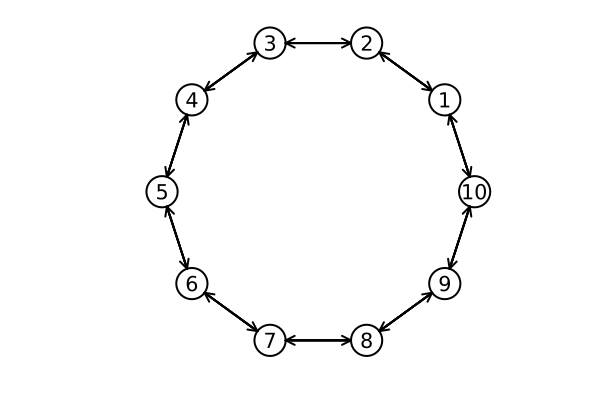

In [7]:
# Create and plot a 10-vertex circle graph
g = circle_graph(10)
plot(g)

## Modifying a Graph

Because our graph is just a collection of Julia arrays, we can easily modify it using standard functions like `push!`, `pop!`, `append!`, and `filter!`.

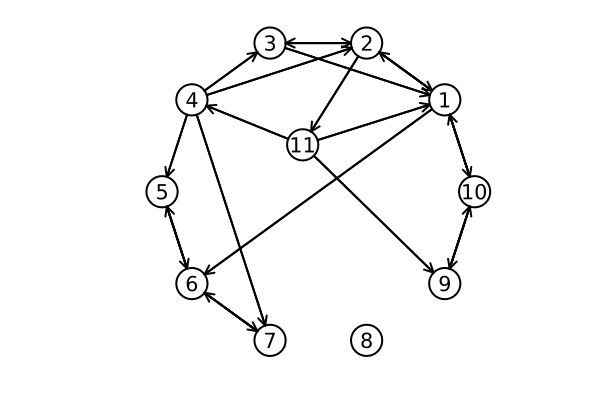

In [8]:
# Start with a fresh 10-vertex circle graph
g = circle_graph(10)

# --- Add edges ---
# Add a single new edge from vertex 1 to 6
push!(g.vertices[1].neighbors, 6);       
# Add two new edges from vertex 4 (to 2 and 7)
append!(g.vertices[4].neighbors, [2,7]);

# --- Change edges ---
# Change the first neighbor of vertex 3 to be vertex 1
g.vertices[3].neighbors[1] = 1           

# --- Remove edges ---
# Remove the last neighbor from vertex 5's list
pop!(g.vertices[5].neighbors)            

# --- Add a new vertex ---
# Note: The new vertex is #11 (the new length of g.vertices)
newv = Vertex([1,4,9], coordinates=[-.1,.3])
push!(g.vertices, newv)
# Add an edge from vertex 2 *to* our new vertex 11
push!(g.vertices[2].neighbors, 11)

# --- "Delete" a vertex (by removing all its edges) ---
# This is tricky, as it requires re-numbering all vertices.
# A simpler way is to just isolate it by removing its edges.
# Here, we isolate vertex 8.

# 1. Remove all *outgoing* edges from vertex 8
resize!(g.vertices[8].neighbors, 0)

# 2. Remove all *incoming* edges to vertex 8
for v in g.vertices
    # filter! keeps only neighbors 'i' that are NOT 8
    filter!(i -> i != 8, v.neighbors)
end

# Plot the final, modified graph
plot(g)